# Summative: mental health perception differences between men and women working in the tech industry

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns

In [2]:
osmi_17 = pd.read_csv('OSMI Mental Health in Tech Survey 2017.csv')
osmi_17 = osmi_17.set_index('#')
display(osmi_17.head(3))

,<strong>Are you self-employed?</strong>,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided health coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?",...,What is your gender?,What country do you <strong>live</strong> in?,What US state or territory do you <strong>live</strong> in?,What is your race?,Other.3,What country do you <strong>work</strong> in?,What US state or territory do you <strong>work</strong> in?,Start Date (UTC),Submit Date (UTC),Network ID
#,,,,,,,,,,,,,,,,,,,,,
e49fe87572831232dcfa51b376b22039,0,100-500,1.0,1.0,No,Yes,No,I don't know,I don't know,I don't know,...,Female,United Kingdom,NaN,NaN,NaN,United Kingdom,NaN,2018-05-16 12:32:04,2018-05-16 12:42:40,464b7a12f1
a1eede444ac024928d247a8372d54931,0,100-500,1.0,1.0,Yes,Yes,No,No,I don't know,I don't know,...,male,United Kingdom,NaN,NaN,NaN,United Kingdom,NaN,2018-05-16 12:31:13,2018-05-16 12:40:40,464b7a12f1
37d3fd67f62bd1e0a2dea4f9cd440d98,0,6-25,1.0,1.0,I don't know,No,I don't know,No,Yes,Difficult,...,male,United States of America,Missouri,White,NaN,United States of America,Missouri,2018-05-09 05:34:05,2018-05-09 05:46:04,1eb7e0cb94


## Print column names and indices

In [3]:
for c, col in enumerate(osmi_17.columns):
    print(c, col)

0 <strong>Are you self-employed?</strong>
1 How many employees does your company or organization have?
2 Is your employer primarily a tech company/organization?
3 Is your primary role within your company related to tech/IT?
4 Does your employer provide mental health benefits as part of healthcare coverage?
5 Do you know the options for mental health care available under your employer-provided health coverage?
6 Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
7 Does your employer offer resources to learn more about mental health disorders and options for seeking help?
8 Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
9 If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?
10 Would you feel more comfortable talking to your coworker

## Data processing and cleansing

In [4]:
for c, col in enumerate(osmi_17.columns):
    if c not in (13,16,18,39,42,44,96,98,104,106,108,109,119,120,121): #free text field + 119-121 are timestamps/networkIDs
        print('%s \'%s\' has unique %s values: \n %s' %(c, col, len(osmi_17.iloc[:,c].unique()), osmi_17.iloc[:,c].unique()))

0 '<strong>Are you self-employed?</strong>' has unique 2 values: 
 [0 1]
1 'How many employees does your company or organization have?' has unique 7 values: 
 ['100-500' '6-25' 'More than 1000' nan '26-100' '1-5' '500-1000']
2 'Is your employer primarily a tech company/organization?' has unique 3 values: 
 [ 1. nan  0.]
3 'Is your primary role within your company related to tech/IT?' has unique 3 values: 
 [ 1. nan  0.]
4 'Does your employer provide mental health benefits as part of healthcare coverage?' has unique 5 values: 
 ['No' 'Yes' "I don't know" nan 'Not eligible for coverage / NA']
5 'Do you know the options for mental health care available under your employer-provided health coverage?' has unique 3 values: 
 ['Yes' 'No' nan]
6 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?' has unique 4 values: 
 ['No' "I don't know" nan 'Yes']
7 'Does your employer offer resources to learn more about men

In [5]:
#duplicated network ID (same person?)
dup = osmi_17[osmi_17['Network ID'].isin(osmi_17['Network ID'][osmi_17.duplicated(subset = ['Network ID'])])]
dup = dup.sort_values(by='Network ID')
#answers are different enough that it doesn't seem to be the same person. Probably use the same IP address at company

In [6]:
#look at nan:
print(len(osmi_17[np.isnan(osmi_17.iloc[:,2])]))
print(len(osmi_17[np.isnan(osmi_17.iloc[:,3])]))
print(len(osmi_17[np.isnan(osmi_17.iloc[:,12])]))
print(len(osmi_17[np.isnan(osmi_17.iloc[:,15])]))

#113 people have not filled out the survey properly. For now we just checked these 4 columns but it seems like they are consistent
#these are actually the ones who are self-employed!!!
df_osmi_17_emp = osmi_17[osmi_17.iloc[:,0] == 0]
df_osmi_17_self = osmi_17[~osmi_17.index.isin(df_osmi_17_emp.index)]

print(len(df_osmi_17_emp), len(df_osmi_17_self), len(osmi_17))

113
113
113
113
643 113 756


In [7]:
#cleanse data: lower case and strip spaces
df_osmi_17_emp = df_osmi_17_emp.apply(lambda x: x.str.strip() if x.dtype=='O' else x)
df_osmi_17_emp = df_osmi_17_emp.apply(lambda x: x.str.lower() if x.dtype=='O' else x)

In [8]:
#look at all the variables with type O

lu_table = {}

for c, col in enumerate(df_osmi_17_emp.columns):
    if df_osmi_17_emp.iloc[:,c].dtype == 'O': #if they are already numbers, we don't need a look up table
        #For now, ignore some of the descriptive columns as we just want men vs women for the perception questions
        #some are free text which we ignore
        if c not in (13,16,18,39,42,44,96,98,104,106,108,109,118):
            lu_table[str(c) + col] = pd.DataFrame(data=df_osmi_17_emp.iloc[:,c].unique(),columns = {'label'})

## Select the variables and clean them
rename columns we are interested in

11 Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?

14 Would you feel comfortable discussing a mental health issue with your coworkers?

In [9]:
#dependent variables (stigma at work)
df = df_osmi_17_emp.rename(columns = {'Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?':'comf_supervisors',
                                      'Would you feel comfortable discussing a mental health issue with your coworkers?':'comf_coworkers'
                                     })

#independent variables
df = df.rename(columns = {'What is your gender?' : 'gender',
                          'What country do you <strong>work</strong> in?':'country',
                          'Have you ever been diagnosed with a mental health disorder?':'diagnosed_mh',
                          'What is your age?':'age'
                         })

**Independent variables**

In [10]:
# code gender given that it was a free text field. Tried to code it into male, female and non-binary
def gender(x):
    if x in ('female','f','woman','femalw','femail','female (cis)','my sex is female.','female (cisgender)',
             'cis-female','cis female','f, cisgender'):
        sex = 'f'
    elif x in ('male','m','man','cis-male','mail','cis hetero male','male (cis)','cis male','male-ish','dude'):
        sex = 'm'
    elif x in ('genderfluid','nonbinary','uhhhhhhhhh fem genderqueer?','non-binary','agender/genderfluid',
                'contextual','non binary','genderqueer demigirl','genderqueer/non-binary','transfeminine','none',
               'god king of the valajar', 'sometimes', '\-', np.nan):
        sex = 'nb'  #explicitely coding them so i keep track
        
    return sex
df['gender'] = df['gender'].map(lambda x: gender(x))

In [11]:
lu = pd.DataFrame({'employee_label':['1-5','6-25','26-100','100-500','500-1000','more than 1000'],
                                'emp_more_than':[1,6,26,100,500,1000]})
df = df.merge(lu, left_on = 'How many employees does your company or organization have?',right_on = 'employee_label')

In [12]:
# df_dummies = pd.get_dummies(df) #only want dummies for our IV??
# print(df_dummies)

## Data exploration

In [13]:
countries = pd.DataFrame()
countries['percent'] = pd.Series(df['country']).value_counts(normalize=True, sort=True)*100
countries['cum_percent'] = np.cumsum(countries['percent'])

print(countries.head(10))
# sns.countplot()

                            percent  cum_percent
united states of america  70.917574    70.917574
united kingdom             8.087092    79.004666
germany                    2.643857    81.648523
canada                     2.332815    83.981337
france                     2.177294    86.158631
spain                      2.021773    88.180404
netherlands                1.555210    89.735614
india                      1.244168    90.979782
australia                  1.244168    92.223950
switzerland                0.622084    92.846034


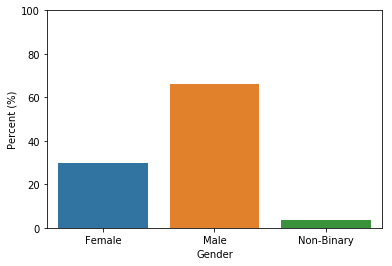

In [41]:
x = df['gender']
y = pd.Series(x).value_counts(normalize=True, sort=True)*100

ax = sns.barplot(x=y.index, y=y, order = ['f', 'm', 'nb']) #,  estimator=percentage)
ax.set(xlabel='Gender',ylabel="Percent (%)")
# axes = plt.gca()
plt.gca().set_ylim([0,100])
plt.xticks(np.arange(3), ('Female', 'Male','Non-Binary'))
plt.savefig('img/Gender_dist.png')
plt.show()


#non-binary is too small a population

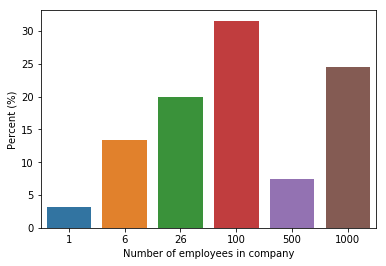

In [15]:
x = df['emp_more_than']
y = pd.Series(x).value_counts(normalize=True, sort=True)*100

ax = sns.barplot(x=y.index, y=y) #,  estimator=percentage)
ax.set(xlabel='Number of employees in company',ylabel="Percent (%)")
# plt.xticks(np.arange(3), ('Female', 'Male', 'Non-Binary'))
plt.show()
#non-binary is too small a population

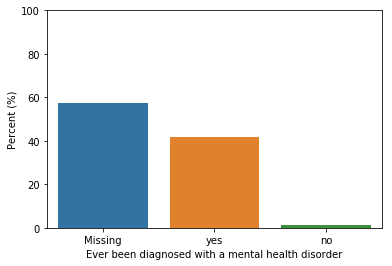

In [34]:
x = df['diagnosed_mh'].fillna('Missing')
y = pd.Series(x).value_counts(normalize=True, sort=True, dropna = False)*100

ax = sns.barplot(x=y.index, y=y) #,  estimator=percentage)
ax.set(xlabel='Ever been diagnosed with a mental health disorder',ylabel="Percent (%)")
# plt.xticks(np.arange(3), ('Missing','Yes', 'No'))
plt.gca().set_ylim([0,100])
plt.savefig('img/mh_diagnosed.png')
plt.show()

In [17]:
df['age'].describe()

count    643.000000
mean      34.656299
std        8.055787
min       18.000000
25%       29.000000
50%       34.000000
75%       39.500000
max       66.000000
Name: age, dtype: float64

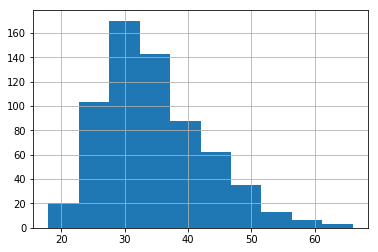

In [23]:
df['age'].hist()

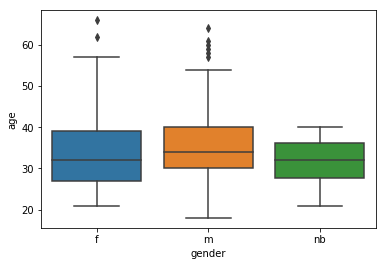

In [21]:
sns.boxplot(x="gender", y="age", data=df)
plt.savefig('img/age.png')
plt.show()

Print unique values in each column
Needed to be able to cleanse the data as this is not provided

## Bivariate relationship between gender and DVs

In [1426]:
pd.crosstab(df['gender'],df['comf_supervisors'])

comf_supervisors,maybe,no,yes
gender,,,
f,62,60,71
m,148,100,178
nb,11,6,7


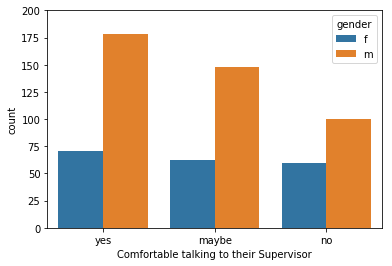

In [35]:
#continuous variables:
import seaborn as sns


sns.countplot(x="comf_supervisors", hue="gender", data=df[df['gender']!='nb'])
plt.xlabel('Comfortable talking to their Supervisor')
plt.gca().set_ylim([0,200])
plt.savefig('img/gender_supervisor.png')
# sns.distplot(df[df['gender'] == 'm']['comf_supervisors'],label='Men')
# sns.distplot(df[df['gender'] == 'f']['comf_supervisors'],label='Women')
# sns.distplot(df[df['gender'] == 'nb']['comf_supervisors'],label='Non-binary')
# plt.legend()

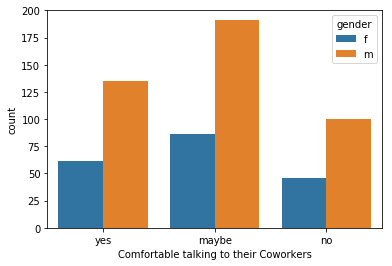

In [36]:
sns.countplot(x="comf_coworkers", hue="gender", data=df[df['gender']!='nb'])
plt.xlabel('Comfortable talking to their Coworkers')
plt.gca().set_ylim([0,200])
plt.savefig('img/gender_coworker.png')


At first glance, doesn't seem that the response is associated with gender. We want to use logistic regression to look at this association and add control variables

We exclude self-employed and non-binary

## Confounding variables

What if the male and female population are not like for like? It's not fair to compare them. We want to see that for **comparable** groups, is there a difference?

Multinomial logistic regression: adding control variables and interaction effects to see if gender ever becomes significant
interaction only makes sense when variables are not categorical

In [46]:
df = df.rename(columns = {'Is your primary role within your company related to tech/IT?':'tech_role',
                          'Have you ever discussed your mental health with your employer?':'discussed_employer',
                          'Does your employer provide mental health benefits\xa0as part of healthcare coverage?':'mh_benefits',
                        'Do you know the options for mental health care available under your employer-provided health coverage?':'mh_options_know',
                        'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?':'mh_comms',
                        'Does your employer offer resources to learn more about mental health disorders and options for seeking help?':'mh_resources',
                        'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?':'medical_leave',
                        'Have you ever discussed your mental health with your employer?':'discussed_employer',
                        'Have you ever discussed your mental health with coworkers?':'coworker_discuss',
                        'Have you ever had a coworker discuss their or another coworker\'s mental health with you?':'coworker_discuss2',
                        'Overall, how much importance does your employer place on mental health?':'mh_importance',
                        'Have you had a mental health disorder in the past?':'mh_past',
                        'Have you ever sought treatment for a mental health disorder from a mental health professional?':'mh_treatment',
                        'Do you have a family history of mental illness?':'family_hist',
                        'Have your observations of how another individual who discussed a mental health issue made you less likely to reveal a mental health issue yourself in your current workplace?':'mh_putoff',
                        'Are you openly identified at work as a person with a mental health issue?':'mh_open',
                        '<strong>Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?</strong>':'unsupportive',
                        '<strong>Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?</strong>':'supportive',
                        'Overall, how well do you think the tech industry supports employees with mental health issues?':'tech_support',                   
                        'How willing would you be to share with friends and family that you have a mental illness?':'share_friends'
                          })

In [47]:
score_lu = pd.DataFrame({'survey_answer':['very easy', 'somewhat easy', 'neither easy nor difficult', 'somewhat difficult', 
                                          'difficult', 'i don\'t know'],'survey_scale':[0,1,2,3,4,np.nan]})
df2 = df.merge(score_lu, left_on = 'medical_leave', right_on = 'survey_answer')

In [48]:
df2 = df2.drop(columns = 'medical_leave').rename(columns = {'survey_scale':'medical_leave'})
df2 = df2[df2['gender']!='nb'] #remove nb as too few

In [49]:
# IV: What and how the variables were used:
df_logit = pd.DataFrame()

#-----------------------------------------------------------------------
#---------demographic & personal experience with MH---------------------
#What is your gender? m/f dummy
df_logit['gender']=df2['gender']
df_logit['gender_f'] = df2['gender'].apply(lambda x: 1 if x=='f' else 0)

#What is your age? integers
df_logit['age'] = df2['age']

# Have you ever been diagnosed with a mental health disorder? IV dummy (yes, [no, missing])
#we choose diagnosis over self-diagnosed question (was also somewhat colinear to diagnosed_mh)
df_logit['diagnosed_mh'] = df2['diagnosed_mh'].apply(lambda x: 1 if x=='yes' else 0)

#How willing would you be to share with friends and family that you have a mental illness? scale 0-10
df_logit['share_friends'] = df2['share_friends']


#-----------------------------------------------------------------------
#----------company info and corresponding mh support--------------------
#several potential questions but focused on those about communication of employer & health-seeking option

# * 6 Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)? IV dummy (yes, [no, i don't know])
df_logit['mh_comms_y'] = df2['mh_comms'].apply(lambda x: 1 if x=='yes' else 0)

# * 7 Does your employer offer resources to learn more about mental health disorders and options for seeking help? (IV dummy (yes, [no, i don't know])
df_logit['mh_resources_y'] = df2['mh_resources'].apply(lambda x: 1 if x=='yes' else 0)

# * 9 If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave? IV scale with i don't know as dummy
df_logit['medical_leave_scale'] = df2['medical_leave'].fillna(2) #impute dont know with the same as 'neither easy nor difficult'

# * 20 Overall, how much importance does your employer place on mental health? IV scale 0-10 (none - a great deal)
df_logit['mh_importance'] = df2['mh_importance']

# * 107 Overall, how well do you think the tech industry supports employees with mental health issues? IV 1-5 (star rating)
df_logit['tech_support'] = df2['tech_support']

#-----------------------------------------------------------------------
#---------company culture and personal mh experiences at work-----------
# * 12 Have you ever discussed your mental health with your employer? IV (binary)
df_logit['discussed_employer'] = df2['discussed_employer']

# * 15 Have you ever discussed your mental health with coworkers? IV (binary)
df_logit['coworker_discuss'] = df2['coworker_discuss']

# * 17 Have you ever had a coworker discuss their or another coworker's mental health with you? IV (1, [0,missing])
df_logit['coworker_discuss2'] = df2['coworker_discuss2'].fillna(0)

#Have your observations of how another individual who discussed a mental health issue made you less likely to reveal a mental health issue yourself in your current workplace? 
# IV dummy (yes, no, [maybe, missing])
df_logit['mh_putoff_y'] = df2['mh_putoff'].apply(lambda x: 1 if x=='yes' else 0)
# df_logit['mh_putoff_n'] = df2['mh_putoff'].apply(lambda x: 1 if x=='no' else 0)

# * 99 Are you openly identified at work as a person with a mental health issue? IV binary
df_logit['mh_open'] = df2['mh_open']

# * 103 <strong>Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?</strong> 
#IV dummy (no, maybe/not sure, ['yes, i observed', 'yes, i experienced'])
# df_logit['unsupportive_n'] = df2['unsupportive'].apply(lambda x: 1 if x=='no' else 0)
df_logit['unsupportive_y'] = df2['unsupportive'].apply(lambda x: 1 if x in ('yes, i observed','yes, i experienced') else 0)

# * 105 <strong>Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?</strong> 
#IV dummy (no, [maybe/not sure, i've always been self employed],['yes, i observed', 'yes, i experienced'])
# df_logit['supportive_n'] = df2['supportive'].apply(lambda x: 1 if x=='no' else 0)
# df_logit['supportive_y'] = df2['supportive'].apply(lambda x: 1 if x in ('yes, i observed','yes, i experienced') else 0)

## Investigate bivariate relationships between gender and IVs
Demographic variables first

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


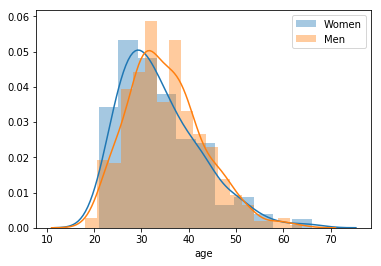

In [50]:
import seaborn as sns

col = 'age' #,'share_friends','medical_leave_scale','mh_importance','tech_support']:
sns.distplot(df_logit[df_logit['gender_f'] == 1][col],label='Women')
sns.distplot(df_logit[df_logit['gender_f'] == 0][col],label='Men')

plt.legend()

# for col in ['age','share_friends','medical_leave_scale','mh_importance','tech_support']:
#     display(df_logit[['gender_f',col]].corr())

## Personal experience

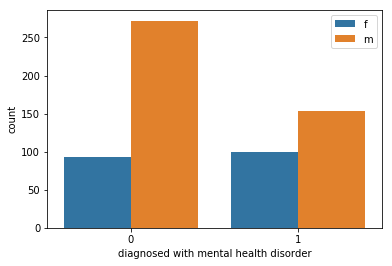

In [29]:
col = 'diagnosed_mh' #,'share_friends','medical_leave_scale','mh_importance','tech_support']:

sns.countplot(x=col, hue="gender", data=df_logit)
plt.xlabel('diagnosed with mental health disorder')
plt.savefig('img/diagnosed.png')
plt.legend()

In [1604]:
(df_logit['gender_f']==1).sum()
# sns.distplot(df_logit[df_logit['gender_f']==0][col])

193

In [1605]:
df_logit[df_logit['gender_f']==1][col].value_counts()/(df_logit['gender_f']==1).sum()


1    0.518135
0    0.481865
Name: diagnosed_mh, dtype: float64

In [1607]:
df_logit[df_logit['gender_f']==0][col].value_counts()/(df_logit['gender_f']==0).sum()


0    0.638498
1    0.361502
Name: diagnosed_mh, dtype: float64

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


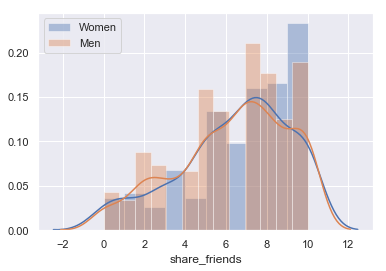

In [1520]:
col = 'share_friends'
sns.distplot(df_logit[df_logit['gender_f'] == 1][col],label='Women')
sns.distplot(df_logit[df_logit['gender_f'] == 0][col],label='Men')

plt.legend()

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


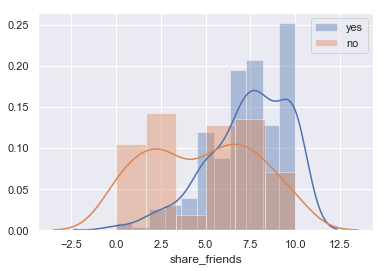

In [1609]:
col = 'share_friends'
sns.distplot(df2[df2['comf_supervisors'] == 'yes'][col],label='yes')
sns.distplot(df2[df2['comf_supervisors'] == 'no'][col],label='no')

plt.legend()

## company info and corresponding mh support

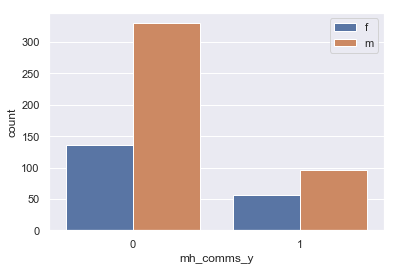

In [1522]:
col = 'mh_comms_y' 
sns.countplot(x=col, hue="gender", data=df_logit)
plt.legend()

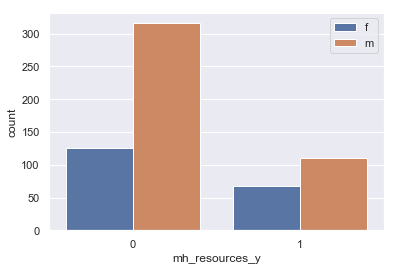

In [1523]:
col = 'mh_resources_y' 
sns.countplot(x=col, hue="gender", data=df_logit)
plt.legend()

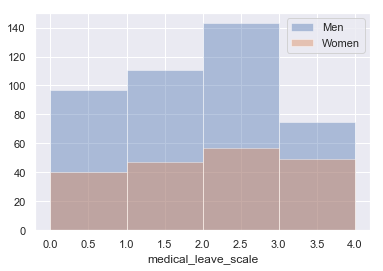

In [1542]:
col = 'medical_leave_scale'
# sns.distplot(df_logit[df_logit['gender_f'] == 1][col],label='Women',norm_hist=False)
sns.distplot(df_logit[df_logit['gender_f'] == 0][col],label='Men',kde=0,norm_hist=False, bins=np.arange(df_logit[df_logit['gender_f'] == 0][col].min(), df_logit[df_logit['gender_f'] == 0][col].max() + 1))
sns.distplot(df_logit[df_logit['gender_f'] == 1][col],label='Women',kde=0,norm_hist=False, bins=np.arange(df_logit[df_logit['gender_f'] == 0][col].min(), df_logit[df_logit['gender_f'] == 0][col].max() + 1))

plt.legend()

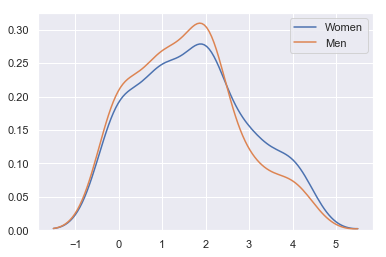

In [1555]:
sns.kdeplot(df_logit[df_logit['gender_f'] == 1][col], bw=0.5, label = 'Women')
sns.kdeplot(df_logit[df_logit['gender_f'] == 0][col], bw=0.5, label = 'Men')

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


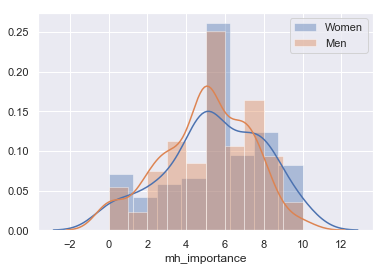

In [1524]:
col = 'mh_importance'
sns.distplot(df_logit[df_logit['gender_f'] == 1][col],label='Women')
sns.distplot(df_logit[df_logit['gender_f'] == 0][col],label='Men')

plt.legend()

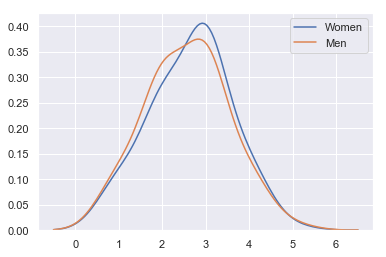

In [1558]:
# * 107 Overall, how well do you think the tech industry supports employees with mental health issues? IV 1-5 (star rating)

col = 'tech_support'
sns.kdeplot(df_logit[df_logit['gender_f'] == 1][col], bw=0.5, label = 'Women')
sns.kdeplot(df_logit[df_logit['gender_f'] == 0][col], bw=0.5, label = 'Men')

plt.legend()

## company culture and personal mh experiences at work

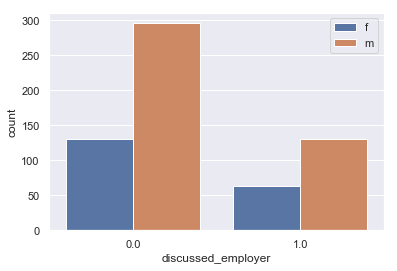

In [1559]:
col = 'discussed_employer' 
sns.countplot(x=col, hue="gender", data=df_logit)
plt.legend()

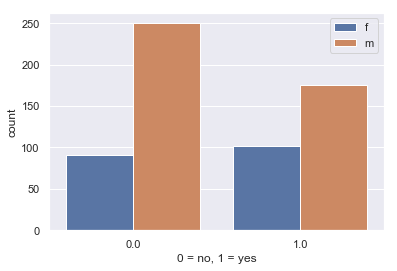

In [1778]:
col = 'coworker_discuss' 
sns.countplot(x=col, hue="gender", data=df_logit)
plt.xlabel('0 = no, 1 = yes')
# plt.title('Have you ever discussed your mental health with coworkers?')
plt.legend()
plt.savefig('img/coworker_discuss.png')

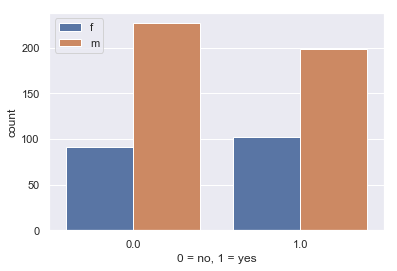

In [1777]:
col = 'coworker_discuss2' 
sns.countplot(x=col, hue="gender", data=df_logit)
plt.xlabel('0 = no, 1 = yes')
# plt.title('Have you ever had a coworker discuss their or another coworker\'s mental health with you?')
plt.legend()
plt.savefig('img/coworker_discuss2.png')

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


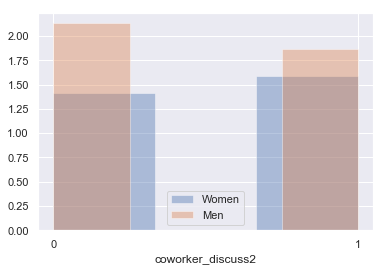

In [1616]:
col = 'coworker_discuss2' 
sns.distplot(df_logit[df_logit['gender_f'] == 1][col],kde=0,norm_hist=1,label='Women')
sns.distplot(df_logit[df_logit['gender_f'] == 0][col],kde=0,norm_hist=1,label='Men')
plt.xticks([0,1])
plt.legend()

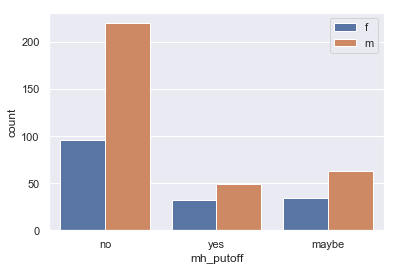

In [1563]:
col = 'mh_putoff' 
sns.countplot(x=col, hue="gender", data=df2)
plt.legend()

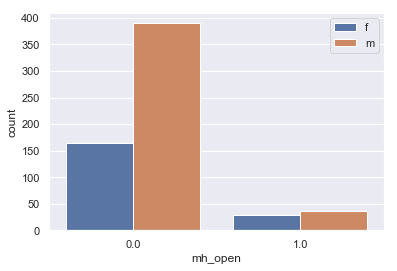

In [1564]:
# * 99 Are you openly identified at work as a person with a mental health issue? IV binary
col = 'mh_open' 
sns.countplot(x=col, hue="gender", data=df_logit)
plt.legend()

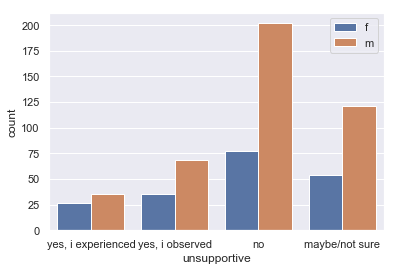

In [1565]:
col = 'unsupportive' 
sns.countplot(x=col, hue="gender", data=df2)
plt.legend()

## Logistic regression

### Colinearity is an issue
We can test for this as follows (simple correlation works as well but this is easier to interpret):

In [52]:
# xs = np.random.randn(100, 5)      # independent variables
corr = np.corrcoef(df_logit.drop(columns='gender'), rowvar=0)  # correlation matrix
w, v = np.linalg.eig(corr)        # eigen values & eigen vectors
w
# X.corr()

array([2.77143034, 2.00162932, 1.4751474 , 1.15362434, 0.98855524,
       0.9190125 , 0.46269286, 0.47040141, 0.52527301, 0.56358274,
       0.64330841, 0.68104121, 0.75098429, 0.80818652, 0.78513039])

In [1352]:
#entry of index 7 is the one closest to 0. Arguably not close enough to indicate colinearity but we can check anyway
#the corresponding eigenvector is:
# v[:,7]

In [1353]:
#ignoring the almost 0 coefficients, this shows that the columns of index 3 and 7 are somewhat colinear.
#this is:
# print(df_logit.columns[3],df_logit.columns[7])

Confounding variables:

discussed_employer and comf_supervisors: if you have already spoken to them, you might be more comfortable? although not necessarily as it could be a bad experience and also, doesn't mean it is direct supervisor

In [55]:
DV_cat = ['comf_supervisors','comf_coworkers']

In [56]:
X = df_logit.drop(columns = 'gender')
X_const = sm.add_constant(X) #add constant

#changing order so that 'yes' becomes reference category
y = df2[DV_cat[0]].apply(lambda x: '1_yes' if x == 'yes' else 
                         ('2_maybe' if x == 'maybe' else '3_no'))
model = sm.MNLogit(y, X_const)
results = model.fit()
print(results.summary())
print(results.model._ynames_map)

Optimization terminated successfully.
         Current function value: 0.879540
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:       comf_supervisors   No. Observations:                  619
Model:                        MNLogit   Df Residuals:                      585
Method:                           MLE   Df Model:                           32
Date:                Sun, 13 Jan 2019   Pseudo R-squ.:                  0.1877
Time:                        10:03:59   Log-Likelihood:                -544.44
converged:                       True   LL-Null:                       -670.23
                                        LLR p-value:                 6.321e-36
comf_supervisors=2_maybe       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.2175      0.779      2.848      0.004       0.691

In [57]:
latex_model = results.summary().as_latex()
print(latex_model)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}             & comf_supervisors & \textbf{  No. Observations:  } &      619    \\
\textbf{Model:}                     &     MNLogit      & \textbf{  Df Residuals:      } &      585    \\
\textbf{Method:}                    &       MLE        & \textbf{  Df Model:          } &       32    \\
\textbf{Date:}                      & Sun, 13 Jan 2019 & \textbf{  Pseudo R-squ.:     } &   0.1877    \\
\textbf{Time:}                      &     10:04:00     & \textbf{  Log-Likelihood:    } &   -544.44   \\
\textbf{converged:}                 &       True       & \textbf{  LL-Null:           } &   -670.23   \\
\bottomrule
\end{tabular}
\begin{tabular}{ccccccc}
\textbf{comf\_supervisors=2\_maybe} & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$>$$|$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
\textbf{const}                      &       2.2175  &        0.779

In [58]:
#changing order so that 'yes' becomes reference category
y = df2[DV_cat[1]].apply(lambda x: '1_yes' if x == 'yes' else 
                         ('2_maybe' if x == 'maybe' else '3_no'))
model = sm.MNLogit(y, X_const)
results = model.fit()
print(results.summary())
print(results.model._ynames_map)

Optimization terminated successfully.
         Current function value: 0.810656
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:         comf_coworkers   No. Observations:                  619
Model:                        MNLogit   Df Residuals:                      585
Method:                           MLE   Df Model:                           32
Date:                Sun, 13 Jan 2019   Pseudo R-squ.:                  0.2386
Time:                        10:04:01   Log-Likelihood:                -501.80
converged:                       True   LL-Null:                       -659.03
                                        LLR p-value:                 3.893e-48
comf_coworkers=2_maybe       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.7369      0.818      0.901      0.368      -0.866      

In [59]:
latex_model = results.summary().as_latex()
print(latex_model)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}           &  comf_coworkers  & \textbf{  No. Observations:  } &      619    \\
\textbf{Model:}                   &     MNLogit      & \textbf{  Df Residuals:      } &      585    \\
\textbf{Method:}                  &       MLE        & \textbf{  Df Model:          } &       32    \\
\textbf{Date:}                    & Sun, 13 Jan 2019 & \textbf{  Pseudo R-squ.:     } &   0.2386    \\
\textbf{Time:}                    &     10:04:01     & \textbf{  Log-Likelihood:    } &   -501.80   \\
\textbf{converged:}               &       True       & \textbf{  LL-Null:           } &   -659.03   \\
\bottomrule
\end{tabular}
\begin{tabular}{ccccccc}
\textbf{comf\_coworkers=2\_maybe} & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$>$$|$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
\textbf{const}                    &       0.7369  &        0.818     &     0.901

Notes: https://stats.idre.ucla.edu/stata/output/multinomial-logistic-regression-2/

LLR p value << 0.05 (log likelihood ratio test significant)

"the standard interpretation of the multinomial logit is that for a unit change in the predictor variable, the logit of outcome m relative to the referent group is expected to change by its respective parameter estimate given the variables in the model are held constant." e.g. for 1 unit change of unsupportive_n, multinomial log-odds for 'yes' relative to referrent 'maybe' is expected to increase by 0.9605 given the variables in the model are held constant


Bad experiences (unsupportive) is more significant than supportive

In [60]:
#interactions with gender
df_logit['gender_f:age'] = df_logit['gender_f']*df_logit['age']

In [72]:
X = df_logit.drop(columns = 'gender')
X_const = sm.add_constant(X) #add constant

#changing order so that 'yes' becomes reference category
y = df2[DV_cat[0]].apply(lambda x: '1_yes' if x == 'yes' else ('2_maybe' if x == 'maybe' else '3_no'))
model = sm.MNLogit(y, X_const)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.879540
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:       comf_supervisors   No. Observations:                  619
Model:                        MNLogit   Df Residuals:                      585
Method:                           MLE   Df Model:                           32
Date:                Sun, 13 Jan 2019   Pseudo R-squ.:                  0.1877
Time:                        10:10:19   Log-Likelihood:                -544.44
converged:                       True   LL-Null:                       -670.23
                                        LLR p-value:                 6.321e-36
comf_supervisors=2_maybe       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.2175      0.779      2.848      0.004       0.691

In [74]:
sup_results = pd.DataFrame()
sup_results['odds maybe'] = np.exp(results.params[0]).round(2).astype(str)
sup_results['significance maybe'] = results.pvalues[0].apply(lambda x: '***' if x<0.01 else ('**' if x<0.05 else ('*' if x<0.1 else '')))
sup_results['odds no'] = np.exp(results.params[1]).round(2).astype(str)
sup_results['significance no'] = results.pvalues[1].apply(lambda x: '***' if x<0.01 else ('**' if x<0.05 else ('*' if x<0.1 else '')))

CI_maybe = pd.DataFrame(np.exp(results._results.conf_int())[0], columns =['0.025','0.975']).round(2).astype(str)
CI_maybe = CI_maybe.set_index(sup_results.index)
CI_no = pd.DataFrame(np.exp(results._results.conf_int())[1], columns =['0.025','0.975']).round(2).astype(str)
CI_no = CI_no.set_index(sup_results.index)


sup_results['odds \'maybe\''] = sup_results['odds maybe']+sup_results['significance maybe']
sup_results['95% CI \'maybe\''] = CI_maybe['0.025'] + ' - ' + CI_maybe['0.975'] 
sup_results['odds \'no\''] = sup_results['odds no']+sup_results['significance no']
sup_results['95% CI \'no\''] = CI_no['0.025'] + ' - ' + CI_no['0.975']

display(sup_results.drop(columns = ['odds maybe','significance maybe','odds no','significance no']))

,odds 'maybe',95% CI 'maybe',odds 'no',95% CI 'no'
const,9.18***,2.0 - 42.25,14.03***,2.22 - 88.63
gender_f,0.32,0.05 - 2.15,0.83,0.09 - 7.9
age,0.98,0.95 - 1.01,1.0,0.96 - 1.03
diagnosed_mh,1.58*,0.96 - 2.63,3.38***,1.84 - 6.2
share_friends,0.87***,0.79 - 0.95,0.7***,0.63 - 0.78
mh_comms_y,1.14,0.66 - 1.98,1.81*,0.91 - 3.6
mh_resources_y,0.93,0.56 - 1.54,0.55*,0.28 - 1.05
medical_leave_scale,1.18*,0.98 - 1.43,1.53***,1.22 - 1.91
mh_importance,0.92,0.83 - 1.02,0.83***,0.73 - 0.94
tech_support,0.9,0.7 - 1.15,0.79,0.58 - 1.06


In [76]:
#changing order so that 'yes' becomes reference category
y = df2[DV_cat[1]].apply(lambda x: '1_yes' if x == 'yes' else ('2_maybe' if x == 'maybe' else '3_no'))
model = sm.MNLogit(y, X_const)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.810656
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:         comf_coworkers   No. Observations:                  619
Model:                        MNLogit   Df Residuals:                      585
Method:                           MLE   Df Model:                           32
Date:                Sun, 13 Jan 2019   Pseudo R-squ.:                  0.2386
Time:                        10:11:15   Log-Likelihood:                -501.80
converged:                       True   LL-Null:                       -659.03
                                        LLR p-value:                 3.893e-48
comf_coworkers=2_maybe       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.7369      0.818      0.901      0.368      -0.866      

In [77]:
co_results = pd.DataFrame()
co_results['odds maybe'] = np.exp(results.params[0]).round(2).astype(str)
co_results['significance maybe'] = results.pvalues[0].apply(lambda x: '***' if x<0.01 else ('**' if x<0.05 else ('*' if x<0.1 else '')))
co_results['odds no'] = np.exp(results.params[1]).round(2).astype(str)
co_results['significance no'] = results.pvalues[1].apply(lambda x: '***' if x<0.01 else ('**' if x<0.05 else ('*' if x<0.1 else '')))

CI_maybe = pd.DataFrame(np.exp(results._results.conf_int())[0], columns =['0.025','0.975']).round(2).astype(str)
CI_maybe = CI_maybe.set_index(co_results.index)
CI_no = pd.DataFrame(np.exp(results._results.conf_int())[1], columns =['0.025','0.975']).round(2).astype(str)
CI_no = CI_no.set_index(co_results.index)

# co_results['0.025no'] = CI_no['0.025']
# co_results['0.975no'] = CI_no['0.975']
co_results['odds \'maybe\''] = co_results['odds maybe']+co_results['significance maybe']
co_results['95% CI \'maybe\''] = CI_maybe['0.025'] + ' - ' + CI_maybe['0.975'] 
co_results['odds \'no\''] = co_results['odds no']+co_results['significance no']
co_results['95% CI \'no\''] = CI_no['0.025'] + ' - ' + CI_no['0.975']

display(co_results.drop(columns = ['odds maybe','significance maybe','odds no','significance no']))

,odds 'maybe',95% CI 'maybe',odds 'no',95% CI 'no'
const,2.09,0.42 - 10.38,13.18**,1.72 - 100.96
gender_f,2.57,0.31 - 21.27,0.88,0.06 - 12.03
age,1.05***,1.01 - 1.08,1.02,0.98 - 1.07
diagnosed_mh,1.98**,1.17 - 3.36,3.1***,1.56 - 6.17
share_friends,0.84***,0.76 - 0.92,0.7***,0.62 - 0.79
mh_comms_y,0.45***,0.25 - 0.8,1.17,0.54 - 2.51
mh_resources_y,1.79**,1.04 - 3.08,0.67,0.32 - 1.43
medical_leave_scale,1.28**,1.04 - 1.56,1.53***,1.19 - 1.96
mh_importance,0.97,0.88 - 1.08,1.0,0.87 - 1.15
tech_support,1.0,0.77 - 1.3,0.64**,0.45 - 0.9


In [78]:
co_results

,odds maybe,significance maybe,odds no,significance no,odds 'maybe',95% CI 'maybe',odds 'no',95% CI 'no'
const,2.09,,13.18,**,2.09,0.42 - 10.38,13.18**,1.72 - 100.96
gender_f,2.57,,0.88,,2.57,0.31 - 21.27,0.88,0.06 - 12.03
age,1.05,***,1.02,,1.05***,1.01 - 1.08,1.02,0.98 - 1.07
diagnosed_mh,1.98,**,3.1,***,1.98**,1.17 - 3.36,3.1***,1.56 - 6.17
share_friends,0.84,***,0.7,***,0.84***,0.76 - 0.92,0.7***,0.62 - 0.79
mh_comms_y,0.45,***,1.17,,0.45***,0.25 - 0.8,1.17,0.54 - 2.51
mh_resources_y,1.79,**,0.67,,1.79**,1.04 - 3.08,0.67,0.32 - 1.43
medical_leave_scale,1.28,**,1.53,***,1.28**,1.04 - 1.56,1.53***,1.19 - 1.96
mh_importance,0.97,,1.0,,0.97,0.88 - 1.08,1.0,0.87 - 1.15
tech_support,1.0,,0.64,**,1.0,0.77 - 1.3,0.64**,0.45 - 0.9


In [1721]:
latex_model = results.summary().as_latex()
print(latex_model)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}           &  comf_coworkers  & \textbf{  No. Observations:  } &      619    \\
\textbf{Model:}                   &     MNLogit      & \textbf{  Df Residuals:      } &      585    \\
\textbf{Method:}                  &       MLE        & \textbf{  Df Model:          } &       32    \\
\textbf{Date:}                    & Wed, 02 Jan 2019 & \textbf{  Pseudo R-squ.:     } &   0.2386    \\
\textbf{Time:}                    &     20:55:20     & \textbf{  Log-Likelihood:    } &   -501.80   \\
\textbf{converged:}               &       True       & \textbf{  LL-Null:           } &   -659.03   \\
\bottomrule
\end{tabular}
\begin{tabular}{ccccccc}
\textbf{comf\_coworkers=2\_maybe} & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$>$$|$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
\textbf{const}                    &       0.7369  &        0.818     &     0.901